## Repeat of the book-crossing dataset recommender example that I wrote for SAS

In [1]:
import html
import numpy as np
import pandas as pd
import re
from io import StringIO
from pathlib import Path

In [2]:
import nvtabular as nvt
import merlin.io

In [3]:
data_dir = Path('/local/var/tmp/mike/bx')
ratings_file = data_dir / "BX-Book-Ratings.csv"
books_file = data_dir / "BX-Books.csv"

In [4]:
with open(books_file, 'r', encoding='iso-8859-1') as f:
    content = html.unescape(f.read())

books_df = pd.read_csv(StringIO(content),
                       header=0, 
                       escapechar='\\',
                       quotechar='"',
                       sep=';', encoding='iso-8859-1',
                       names=['ISBN', 'Title', 'Author', 'Year_Of_Publication', 'Publisher', 'img_url_s', 'img_url_m', 'img_url_l'],
                       usecols=['ISBN', 'Title', 'Author', 'Year_Of_Publication', 'Publisher'],
                       dtype={'ISBN': str, 'Year_Of_Publication': int})

books_df = books_df[books_df.ISBN.str.len() == 10]

books_df.head()

,ISBN,Title,Author,Year_Of_Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


Display the data types:

In [5]:
books_df.dtypes

ISBN                   object
Title                  object
Author                 object
Year_Of_Publication     int64
Publisher              object
dtype: object

Import the ratings data:

In [6]:
isbn_pat = re.compile('"\d+";"[0-9X]{10}";"[1-9][0]?"')
buffer = StringIO()

with open(ratings_file, 'r', encoding='iso-8859-1') as f:
    for line in f:
        if isbn_pat.match(line):
            buffer.write(line)
            
buffer.seek(0)            
ratings_df = pd.read_csv(buffer,
                         skiprows=0,
                         sep=';',
                         names=['User_ID', 'ISBN', 'Rating'],
                         dtype={'User_ID': int, 'ISBN': str, 'Rating': int})
buffer.close()

ratings_df.head()

,User_ID,ISBN,Rating
0,276726,0155061224,5
1,276729,052165615X,3
2,276729,0521795028,6
3,276736,3257224281,8
4,276737,0600570967,6


Display the data types of the ratings data:

In [7]:
ratings_df.dtypes

User_ID     int64
ISBN       object
Rating      int64
dtype: object

## Imitation data quality

* Remove duplicate ratings.
* Remove ratings for ISBNs that are not in the books DataFrame.

In [8]:
print("Ratings count before changes: ", len(ratings_df))

ratings_df.drop_duplicates(inplace=True)

ratings_df = ratings_df[ratings_df.set_index(['ISBN']).index.isin(books_df.set_index(['ISBN']).index)]

print("Ratings count after changes: ", len(ratings_df))

ratings_df.describe()


Ratings count before changes:  428204
Ratings count after changes:  383596


,User_ID,Rating
count,383596.000000,383596.000000
mean,136034.234054,7.626589
std,80484.595981,1.841458
min,8.000000,1.000000
25%,67591.000000,7.000000
50%,133790.000000,8.000000
75%,206219.000000,9.000000
max,278854.000000,10.000000


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   Rating  count
0       1   1479
1       2   2374
2       3   5117
3       4   7612
4       5  45342
5       6  31671
6       7  66352
7       8  91722
8       9  60743
9      10  71184


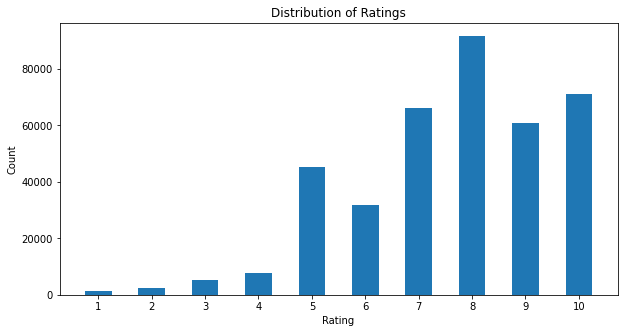

In [9]:
! pip install matplotlib
import matplotlib.pyplot as plt

x = ratings_df.groupby('Rating')['ISBN'].count().reset_index(name="count")
print(x)

# plt.hist(ratings_df.groupby("Rating").count()[['ISBN']], )
fig, ax = plt.subplots()

ax.bar(x['Rating'], x['count'], width=.5)
ax.set_title('Distribution of Ratings')
ax.set_ylabel('Count')
ax.set_xlabel('Rating')
ax.set_xticks(x['Rating'])
fig.set_size_inches(10,5)

plt.show()

## Partition the data into training and validation

After partitioning the data, save the data in Parquet format.

In [10]:
ratings = ratings_df.sample(len(ratings_df), replace=False)
validation_count = int(len(ratings) * 0.33)

train = ratings[:-validation_count]
valid = ratings[-validation_count:]

train = merlin.io.Dataset(train)
train.to_parquet(data_dir / "train.parquet")

valid = merlin.io.Dataset(valid)
valid.to_parquet(data_dir / "valid.parquet")

books = merlin.io.Dataset(books_df)
books.to_parquet(data_dir / "books.parquet")


/home/local/repos/NVTabular/.venv/lib/python3.8/site-packages/merlin/io/dataset.py:252: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


## Attempting to understand how to use NVT's Ops

In the discussion at <https://nvidia-merlin.github.io/NVTabular/main/examples/getting-started-movielens/02-ETL-with-NVTabular.html>,
I'm a little disoriented:

* Before the "Defining our Preprocessing Pipeline", there is a `head()` of the movies data.
That is good because it reinforces my understanding of the data.

* In the "Defining..." section, the **Example** is generic--`features = [ column_name, ... ]...`.
This is slightly disorienting and I'd like to consider if using the same variable names from the data sample could work.

* Right after the generic example, `CATEGORICAL_COLUMNS` and `LABEL_COLUMNS` are defined--and tie to the data sample, which is good, but I'm lost in what we're joining with the `JoinExternal` Op and why `joined.graph` has two tables with inputs of `userID, movieID` and outputs the same two columns.  I'm missing something.

My instinct is that the Movielens example is growing stale.  I switched to looking at <https://nvidia-merlin.github.io/Merlin/main/examples/Building-and-deploying-multi-stage-RecSys/01-Building-Recommender-Systems-with-Merlin.html> for inspiration.

In [11]:
from nvtabular.ops import (
    Categorify,
    Dropna,
    LambdaOp,
    TagAsUserID,
    TagAsItemID,
    TagAsItemFeatures,
    TagAsUserFeatures,
    AddMetadata,
    Filter,
    Rename,
    JoinExternal,
)

from nvtabular import ColumnGroup

from merlin.schema.tags import Tags

from merlin.io.dataset import Dataset

In [12]:
display(train.head())
display(books.head())

,User_ID,ISBN,Rating
198509,120908,0373244487,9
410550,264113,0486414108,10
218891,135061,0451115783,6
285170,179256,9724119378,5
315466,199515,0446610232,10


,ISBN,Title,Author,Year_Of_Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


We need a way to join the training data and the books data on the common column, ISBN.
The `JoinExternal` Op can perform the join.

(The graph that I get does not look like the graph at <https://nvidia-merlin.github.io/NVTabular/main/examples/getting-started-movielens/02-ETL-with-NVTabular.html#defining-our-preprocessing-pipeline>.
I do not know why, but my only suspicion is that the graph does not know about the `train` data.)

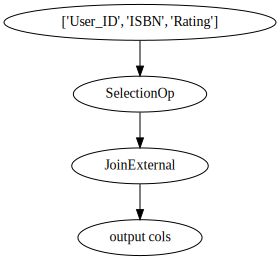

In [13]:

joined = list(train.to_ddf().columns) >> JoinExternal(books, on=["ISBN"])

joined.graph

Perform some data preparation:

* Materialize the join of the books dataset with the training dataset so that we can access the title, author, publisher, and so on.
* In addition, add an `ISBN_onehotencoded` column. We need the column because the `ISBN` column is a string and we need an integer value for the item ID so we can perform modeling.

In [14]:
item_id = ["ISBN"] >> Rename(postfix="_onehotencoded") >> Categorify() >> TagAsItemID()

prepped_ds = nvt.Workflow(joined + item_id).fit_transform(train)

prepped_ds.head()

/home/local/repos/NVTabular/.venv/lib/python3.8/site-packages/merlin/io/dataset.py:408: UserWarning: Changing an NVTabular Dataset to CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/home/local/repos/NVTabular/.venv/lib/python3.8/site-packages/merlin/io/dataset.py:252: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


,User_ID,ISBN,Rating,Title,Author,Year_Of_Publication,Publisher,ISBN_onehotencoded
0,120908,0373244487,9,Cordina's Crown Jewel,Nora Roberts,2002,Silhouette,1467
1,264113,0486414108,10,Song of Myself (Dover Thrift Editions),Walt Whitman,2001,Dover Publications,9986
2,135061,0451115783,6,Pets Are Friends You Like Who Like You Right Back,Tom Wilson,1978,New Amer Library (Mm),105803
3,179256,9724119378,5,O Deus Das Pequenas Coisas,Roy,1998,Edicoes Asa,32368
4,199515,0446610232,10,The Ice Limit,D. Preston,2001,Warner Vision,3203


Perform some data transformation and feature engineering with the Ops available from NVTabular.

In [15]:
user_id = ["User_ID"] >> Categorify() >> TagAsUserID()
# item_id = ["ISBN"] >> Rename(postfix="_onehot") >> Categorify() >> TagAsItemID()

item_features = (
    joined[["Title", "Author", "Year_Of_Publication", "Publisher"]] >> Categorify() >> TagAsItemFeatures()
)

target = ColumnGroup(["Rating"]) >> LambdaOp(lambda col: (col > 7).astype(np.int8)) >> Rename(name="good_or_bad") >> AddMetadata(tags=[Tags.BINARY_CLASSIFICATION, "target"])

For play, view the `LambdaOp` and `Rename` Ops in action on the `Rating` column from the `train` dataset:

In [16]:
print("The data type of target: ", type(target))
workflow = nvt.Workflow(target)
workflow.fit(train)
display(workflow.transform(train).head())

The data type of target:  <class 'nvtabular.workflow.node.WorkflowNode'>


/home/local/repos/NVTabular/.venv/lib/python3.8/site-packages/merlin/io/dataset.py:252: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


,good_or_bad
198509,1
410550,1
218891,0
285170,0
315466,1


Now, run the workflow on the data:

* Define an `output` variable that combines the workflow nodes.  These workflow nodes are the Ops that perform the feature engineering.
* For fun, display the workflow as a graph with graphviz.
* Define a new `workflow` variable that can perform the feature engineering.
* Fit and transform the workflow on the training data and then display the first few rows.

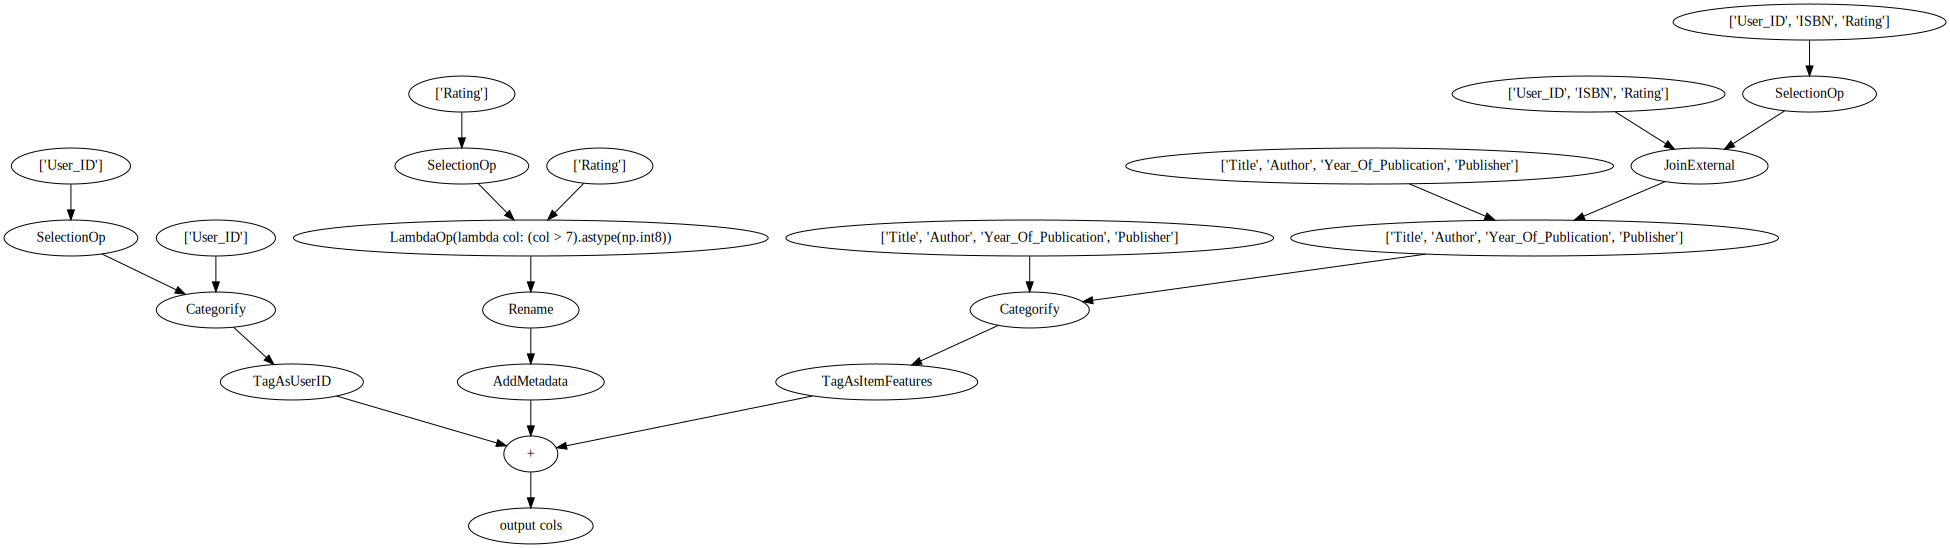

In [22]:
output = item_features + user_id + target

output.graph

For demonstration purposes, specify some columns manually so that we can view the transformed values alongside the original values.

In [23]:
workflow = nvt.Workflow(output + ['Rating', 'ISBN', 'ISBN_onehotencoded'])
workflow.fit(prepped_ds)

/home/local/repos/NVTabular/.venv/lib/python3.8/site-packages/merlin/io/dataset.py:252: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [24]:
training_data = workflow.transform(prepped_ds)

display(training_data.head(n=20))

,Title,Author,Year_Of_Publication,Publisher,User_ID,good_or_bad,Rating,ISBN,ISBN_onehotencoded
0,1629,2,1,21,1662,1,9,0373244487,1467
1,10820,1317,2,53,22778,1,10,0486414108,9986
2,90359,5941,27,182,3895,0,6,0451115783,105803
3,24907,17806,6,4471,10938,0,5,9724119378,32368
4,2503,3328,2,42,1316,1,10,0446610232,3203
5,688,154,10,17,3447,1,10,0440204887,800
6,15622,6547,5,106,3254,1,8,0553579703,18150
7,11519,231,32,93,3860,1,10,0394831292,10719
8,102288,48069,31,178,2577,1,8,0440943205,107543
9,12859,337,11,18,50229,1,8,0671689495,27891
